# Plain vs. Parallel Deep Decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def myimgshow(plt,img):
    plt.gray()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.clip(img[0],0,1),interpolation='nearest')

## Load image

In [3]:
path = './test_data/'
#img_name = "phantom256"
img_name = "brain_sagittal.jpg"
img_path = path + img_name #+ ".png"
img_pil = Image.open(img_path)
img_np = np.array([pil_to_np(img_pil)[0]])
img_np = img_np / np.max(img_np)
img_var = np_to_var(img_np).type(dtype)

In [4]:
img_np.shape,img_var.shape

((1, 256, 256), torch.Size([1, 1, 256, 256]))

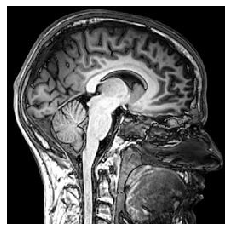

In [5]:
myimgshow(plt,img_np)
plt.axis('off')
#plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()

## Define network

In [25]:
output_depth = img_np.shape[0]
num_channels0 = 104
num_channels = 64
rnd = 500
numit = 10000
rn = 0.001
maxv = np.max(img_np)
in_size = [16,16]
out_size = img_np[0].shape

num_layers0 = 5
plainnet = skipdecoder(out_size,in_size,output_depth,num_layers0,num_channels0,skips=False).type(dtype)

decoders_numlayers_list = [3,4,5] # #layers for each decoding block
decoders_last_channels = [40,40,40]
net = pardecoder(out_size,in_size,num_output_channels = output_depth,
                 num_channels=num_channels,
                 decoders_numlayers_list = decoders_numlayers_list,
                 decoders_last_channels = decoders_last_channels).type(dtype)

print("plain params:",num_param(plainnet))
print("parallel params:", num_param(net),'\n')

print("train parallel") 
mse_n, mse_t, ni, net = fit( in_size=in_size,
                        num_channels=[num_channels]*(max(decoders_numlayers_list)-1),
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=True,
                        #orth_reg=0.1,
                        )
out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
print("parallel psnr:",psnr(img_np,out_img_np,maxv),"\n")

print("train plain") 
mse_n, mse_t, plainni, plainnet = fit( in_size=in_size,
                        num_channels=[num_channels0]*(num_layers0-1),
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        img_noisy_var=img_var,
                        net=plainnet,
                        img_clean_var=img_var,
                        find_best=True,
                        )
out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
print("plain psnr:",psnr(img_np,out_img_np,maxv),"\n")

plain params: 44200
parallel params: 45816 

train parallel
shape:  [1, 64, 16, 16]
optimize with adam 0.0025
parallel psnr: 31.073520356612605 0826  Actual loss 0.000826 Actual loss orig 0.000826  Noise Energy 0.000000 

train plain
shape:  [1, 104, 16, 16]
optimize with adam 0.0025
plain psnr: 30.916891633188957 .001014  Actual loss 0.001014 Actual loss orig 0.001014  Noise Energy 0.000000   



### Visualize parallel deep decoder activations (after each decoder)

In [21]:
def plot_tensor(out,nrows=8):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

##### indivual channels

first decoder


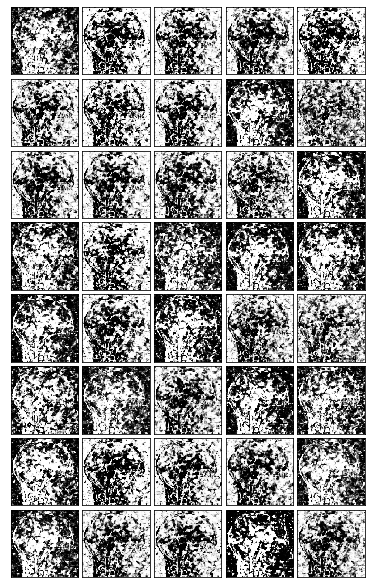

second decoder


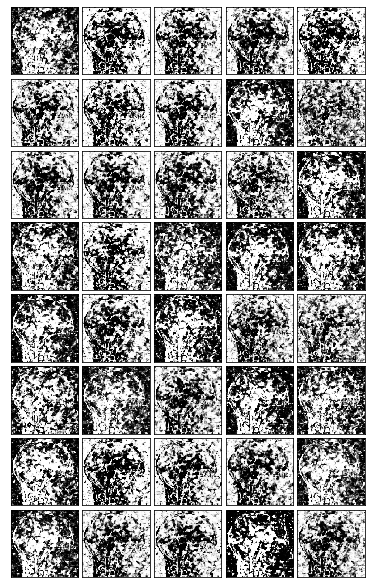

third decoder


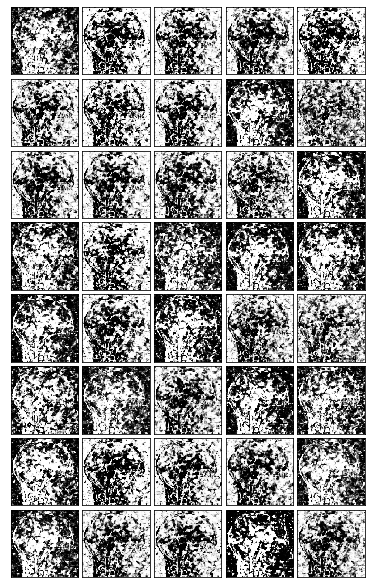

In [26]:
print("first decoder")
out1 = net.net1(ni.type(dtype))
plot_tensor(out)

print("second decoder")
out2 = net.net2(ni.type(dtype))
plot_tensor(out)

print("third decoder")
out3 = net.net3(ni.type(dtype))
plot_tensor(out)

##### mean over channels

first decoder


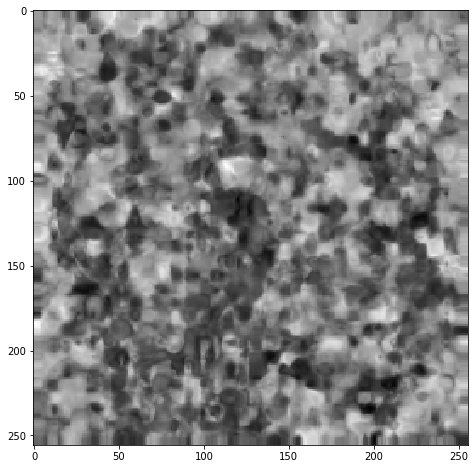

second decoder


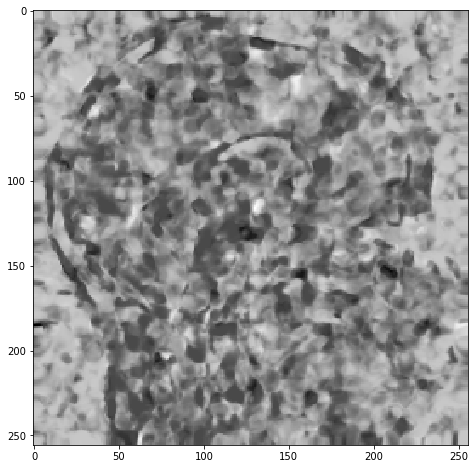

third decoder


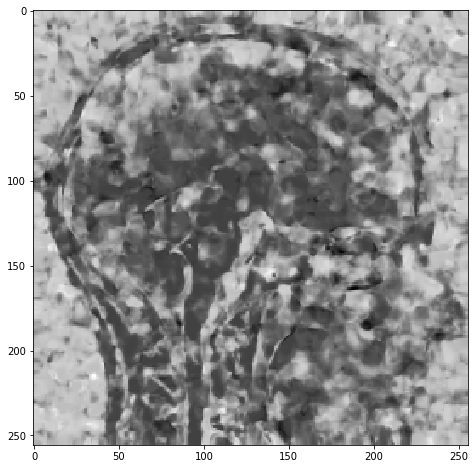

In [23]:
print("first decoder")
plt.imshow(out1.mean(1)[0].data.cpu())
plt.show()

print("second decoder")
plt.imshow(out2.mean(1)[0].data.cpu())
plt.show()

print("third decoder")
plt.imshow(out3.mean(1)[0].data.cpu())
plt.show()

##### The original image

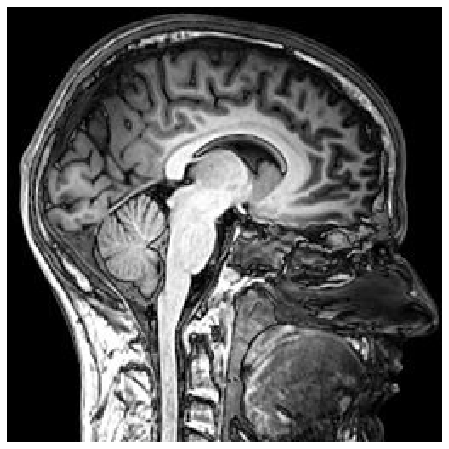

In [24]:
myimgshow(plt,img_np)
plt.axis('off')
plt.show()